Imports

# Imports

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import random
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import json
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# Data Preprocessing

In [3]:
df = pd.read_csv('meta.csv')
df

,gender,path
0,male,wiki_crop/47/30034447_1957-04-20_2011.jpg
1,female,wiki_crop/80/291380_1959-03-11_2013.jpg
2,female,wiki_crop/34/41282534_1994-03-10_2015.jpg
3,male,wiki_crop/64/2446664_1978-10-26_2008.jpg
4,female,wiki_crop/94/24841994_1955-06-11_1981.jpg
...,...,...
40211,male,wiki_crop/33/36348433_1986-05-28_2012.jpg
40212,male,wiki_crop/69/983669_1944-11-14_2006.jpg
40213,male,wiki_crop/62/18151562_1926-05-19_1954.jpg
40214,male,wiki_crop/95/8095_1938-01-10_2005.jpg


In [4]:
# First take out 0.2 for test (this dataset will not be used in the training process)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0, stratify=df['gender'])
# Then split the remaining 0.8 into training and validation
train_df, val_df = train_test_split(train_df, test_size=0.3, random_state=0, stratify=train_df['gender'])

In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# data generator for training data
def train_val_test_generator(batch_size):
  train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                      x_col="path", y_col="gender", 
                                                      target_size=(224,224), batch_size=batch_size, 
                                                      class_mode='binary')

  # data generator for validation data
  validation_generator = validation_datagen.flow_from_dataframe(val_df, 
                                                                x_col="path", y_col="gender", 
                                                                target_size=(224,224), batch_size=batch_size, 
                                                                class_mode='binary')

  # data generator for testing data
  test_generator = test_datagen.flow_from_dataframe(test_df, 
                                                    x_col="path", y_col="gender", 
                                                    target_size=(224,224), batch_size=batch_size, 
                                                    class_mode='binary', shuffle = False)
  
  return train_generator, validation_generator, test_generator

In [ ]:
# Our initial batch size is 128
train_generator, validation_generator, test_generator = train_val_test_generator(128)

In [6]:
def checkpoint(title):
  return tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/NTU/Y4/Y4S1/CZ4042/CZ4042_shared/JW/{}.h5'.format(title), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [7]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=7)

In [8]:
def fit(model, title, train_generator, validation_generator):
  histories[title] = model.fit(train_generator,
                               steps_per_epoch=train_generator.samples/train_generator.batch_size,
                               epochs=100,
                               validation_data=validation_generator,
                               validation_steps=validation_generator.samples/validation_generator.batch_size,
                               verbose=1,
                               callbacks=[early, checkpoint(title)])
  return model

In [9]:
"""
model: your trained model
val_gen: validation generator
base_model: Name of base model -> e.g. DenseNet, VGG16
param_opt: parameter optimised --> <parameter optimised>_<value>, value is optional
E.g. base, dropout_0.5, stacked, bs_64, lr_0.01
save_path: path where you want to save all outputs e.g. './results'
"""

def model_analysis(model, val_gen, base_model, param_opt, save_path='./results'):
  title = '{}_{}'.format(base_model, param_opt)
  print('Results for {}'.format(title))
  prediction = model.predict(val_gen,
                             steps=val_gen.samples/val_gen.batch_size,
                             verbose=1)
  predicted_classes = prediction.flatten()
  predicted_classes[predicted_classes>=0.5] = 1
  predicted_classes[predicted_classes<0.5] = 0
  
  actual = val_gen.classes
  errors = np.where(predicted_classes != actual)[0]
  print("Error rate {}".format(len(errors)/val_gen.samples))
  
  genders = ['Female', 'Male']
  cm = confusion_matrix(actual, predicted_classes)
  sns.heatmap(cm, annot=True, cmap='Blues', fmt="d",
              xticklabels=genders, yticklabels=genders)
  
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.title(title)
  plt.savefig('{}/{}_cm.pdf'.format(save_path, title))
  plt.close()
  
  print(classification_report(actual, predicted_classes, target_names=genders))
  clsf_report = pd.DataFrame(classification_report(actual, predicted_classes, target_names=genders, output_dict=True)).transpose()
  clsf_report.to_csv('{}/{}_cr.csv'.format(save_path, title), index= True)

  # Get AUC ROC Score and save as a file
  roc_auc = roc_auc_score(actual, predicted_classes)
  roc_auc_file = '{}/{}_roc_auc'.format(save_path, title)
  params = {'title': title,
            'roc_auc': roc_auc}
  with open(roc_auc_file, 'w') as fp:
    json.dump(params, fp)
  print("Successfully saved auc_roc file at {}".format(roc_auc_file))

In [10]:
histories = {}

# InceptionV3 Model

In [9]:
# get inceptionV3
inception_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

87916544/87910968 [==============================] - 0s 0us/step


In [11]:
def get_inception_model(lr=0.0001, dropout=0.5, stacked=False):
  # freeze all layers
  for layer in inception_model.layers:
    layer.trainable = False

  inception_transfer_model = tf.keras.models.Sequential()
  inception_transfer_model.add(inception_model)
  inception_transfer_model.add(tf.keras.layers.Flatten())
  inception_transfer_model.add(tf.keras.layers.Dense(1024, activation="relu"))
  inception_transfer_model.add(tf.keras.layers.Dropout(dropout))
  inception_transfer_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  inception_transfer_model.compile(loss='binary_crossentropy',
                                  optimizer=tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                  metrics=['accuracy'])

  inception_transfer_model.summary()
  return inception_transfer_model


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              52429824  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 74,233,633
Trainable params: 52,430,849
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
inception_model = fit(inception_transfer_model, 'inceptionv3_base', train_generator, validation_generator)
validation_generator = validation_datagen.flow_from_dataframe(val_df, 
                                                              x_col="path", y_col="gender", 
                                                              target_size=(224,224), batch_size=batch_size, 
                                                              class_mode='binary', shuffle=False)
model_analysis(inception_model, validation_generator, 'inceptionv3', 'base')

# DenseNet201 Model

In [11]:
# get denseNet
densenet_model = tf.keras.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=1000,
)

74842112/74836368 [==============================] - 3s 0us/step


In [13]:
def get_model(lr=0.0001, dropout=0.5, stacked=False):
  # freeze all layers
  for layer in densenet_model.layers:
    layer.trainable = False

  densenet_transfer_model = tf.keras.models.Sequential()
  densenet_transfer_model.add(densenet_model)
  densenet_transfer_model.add(tf.keras.layers.Flatten())
  densenet_transfer_model.add(tf.keras.layers.Dense(1024, activation="relu"))
  if stacked:
    densenet_transfer_model.add(tf.keras.layers.Dropout(dropout))
    densenet_transfer_model.add(tf.keras.layers.Dense(1024, activation="relu"))
    densenet_transfer_model.add(tf.keras.layers.Dropout(dropout))
  else:
    if dropout==0.2:
      densenet_transfer_model.add(tf.keras.layers.Dropout(0.2))
    elif dropout==0.5:
      densenet_transfer_model.add(tf.keras.layers.Dropout(0.5))
  densenet_transfer_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  densenet_transfer_model.compile(loss='binary_crossentropy',
                                  optimizer=tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                  metrics=['accuracy'])

  densenet_transfer_model.summary()
  return densenet_transfer_model

In [ ]:
densenet_transfer_model = get_model() # get the model with base parameters
densenet_model = fit(densenet_transfer_model, 'densenet201_base', train_generator, validation_generator)
model_analysis(inception_model, validation_generator, 'densenet201', 'base')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
flatten_1 (Flatten)          (None, 94080)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              96338944  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 114,661,953
Trainable params: 96,339,969
Non-trainable params: 18,321,984
_________________________________________________________________
Epoch 1/100
176/175 [==============================] - ETA: 0s - loss: 0.3573 - accuracy: 0.8579
E

In [ ]:
# Pickle history files
with open('inceptionv3_base.pickle', 'wb') as handle:
    pickle.dump(histories['inception_base'].history, handle)
with open('densenet201_base.pickle', 'wb') as handle:
    pickle.dump(histories['densenet_base'].history, handle)

# Hyper-parameter tuning of Densenet model

In [ ]:
# Hyper-parameter tuning of the better model - Densenet

## Batch size

In [ ]:
# 1. Batch Size - currently 128
# Train on 64 and 256
batch_sizes = [64, 256]
for batch_size in batch_sizes:
  param = 'bs{}'.format(batch_size)
  title = 'densenet201_{}'.format(param)
  train_generator, validation_generator, test_generator = train_val_test_generator(batch_size)
  model = get_model()
  model = fit(model, title, train_generator, validation_generator)
  # Setting validation generator to not shuffle in order to correctly analysis the model in model_analysis
  validation_generator = validation_datagen.flow_from_dataframe(val_df, 
                                                              x_col="path", y_col="gender", 
                                                              target_size=(224,224), batch_size=batch_size, 
                                                              class_mode='binary', shuffle=False)
  model_analysis(model, validation_generator, 'densenet201', param)
  # Save the history into a pickle file for easier access and analysis later on
  with open('{}.pickle'.format(title), 'wb') as handle:
    pickle.dump(histories[title].history, handle)

## Dropout

In [56]:
# 2. Dropout - currenly 0.5
# Train with no dropout and 0.2 dropout
lr = 0.0001
batch_size = 128
dropouts = [0, 0.2]
for dropout in dropouts:
  param = 'dropout{}'.format(dropout)
  title = 'densenet201_{}'.format(param)
  train_generator, validation_generator, test_generator = train_val_test_generator(batch_size)
  model = get_model(lr, dropout, False)
  model = fit(model, title, train_generator, validation_generator)
  validation_generator = validation_datagen.flow_from_dataframe(val_df, 
                                                              x_col="path", y_col="gender", 
                                                              target_size=(224,224), batch_size=batch_size, 
                                                              class_mode='binary', shuffle=False)
  model_analysis(model, validation_generator, 'densenet201', param)
  with open('{}.pickle'.format(title), 'wb') as handle:
    pickle.dump(histories[title].history, handle)

Found 22520 validated image filenames belonging to 2 classes.
Found 9652 validated image filenames belonging to 2 classes.
Found 8044 validated image filenames belonging to 2 classes.
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
flatten_6 (Flatten)          (None, 94080)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              96338944  
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 1025      
Total params: 114,661,953
Trainable params: 96,339,969
Non-trainable params: 18,321,984
_________________________________________________________________
Epoch 1/100
176/175 [=========================

## Learning rate

In [14]:
# 3. Learning rate - currently 1e-4
learning_rates=[1e-2, 1e-3]
batch_size = 128
dropout = 0.5
for lr in learning_rates:
  if lr == 0.01:
    name = '1e-2'
  else:
    name = '1e-3'
  param = 'lr{}'.format(name)
  title = 'densenet201_{}'.format(param)
  train_generator, validation_generator, test_generator = train_val_test_generator(batch_size)
  model = get_model(lr, dropout, False)
  model = fit(model, title, train_generator, validation_generator)
  validation_generator = validation_datagen.flow_from_dataframe(val_df, 
                                                              x_col="path", y_col="gender", 
                                                              target_size=(224,224), batch_size=batch_size, 
                                                              class_mode='binary', shuffle=False)
  model_analysis(model, validation_generator, 'densenet201', param)
  with open('{}.pickle'.format(title), 'wb') as handle:
    pickle.dump(histories[title].history, handle)

Found 22520 validated image filenames belonging to 2 classes.
Found 9652 validated image filenames belonging to 2 classes.
Found 8044 validated image filenames belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 94080)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              96338944  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 114,661,953
Trainable params: 96,339,969
Non-trainable p

## Number of layers

In [18]:
# 4. With additional dropout-dense stack
learning_rate = 1e-4
stacked = True
batch_size = 128
dropout = 0.5

param = 'stacked'
title = 'densenet201_{}'.format(param)
train_generator, validation_generator, test_generator = train_val_test_generator(batch_size)
model = get_model(lr, dropout, stacked)
model = fit(model, title, train_generator, validation_generator)
validation_generator = validation_datagen.flow_from_dataframe(val_df, 
                                                              x_col="path", y_col="gender", 
                                                              target_size=(224,224), batch_size=batch_size, 
                                                              class_mode='binary', shuffle=False)
model_analysis(model, validation_generator, 'densenet201', param)
with open('{}.pickle'.format(title), 'wb') as handle:
  pickle.dump(histories[title].history, handle)

Found 22520 validated image filenames belonging to 2 classes.
Found 9652 validated image filenames belonging to 2 classes.
Found 8044 validated image filenames belonging to 2 classes.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
flatten_3 (Flatten)          (None, 94080)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              96338944  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dr

# Plotting Bar Graphs

Plotting bar graphs by retrieving previously saved json and csv files

In [161]:
def get_roc_auc(roc_auc_file_path):
  with open(roc_auc_file_path) as f:
    data = json.load(f)
    # Retrieves only roc_auc score from file
    roc_auc = data['roc_auc']

  return roc_auc

def get_f1(csv_file_path):
  # Retrieves only f1 score from csv file
  f1 = pd.read_csv(csv_file_path)._get_value(4, 'f1-score') #f1 score is in row with index 4

  return f1

def get_val(file_path):
  return pd.read_csv(file_path)


In [142]:
def plot_bar_graph(auc_scores, f1_scores, labels, model_title, graph_title, save_path='result'):
  x = np.arange(len(labels))
  width = 0.4
  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, auc_scores, width, label='AUC ROC Score')
  rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score')
  ax.set_ylabel('Scores')
  ax.set_title(graph_title)
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  plt.legend(loc='best')

  def autolabel(rects):
    for rect in rects:
      height = rect.get_height()
      ax.annotate('{:.4f}'.format(height),
                  xy=(rect.get_x() + rect.get_width() / 2, height),
                  xytext=(0, 3),  # 3 points vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom')

  autolabel(rects1)
  autolabel(rects2)

  def min_max(auc_scores, f1_scores):
    min_val = 0
    max_val = 0
    min_auc, max_auc = min(auc_scores), max(auc_scores)
    min_f1, max_f1 = min(f1_scores), max(f1_scores)
    # Setting min and max y_val so that the difference between models are more obvious
    min_val = min(min_auc, min_f1) - 0.01
    max_val = max(max_auc, max_f1) + 0.02
    return min_val, max_val

  min_val, max_val = min_max(auc_scores, f1_scores)
  plt.gca().set_ylim(bottom=min_val, top=max_val)

  plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
  plt.savefig('{}/bar_plots/{}_bar.pdf'.format(save_path, model_title), dpi=100, bbox_inches='tight')
  plt.show()
  plt.close()

In [ ]:
# We will use these parameeters to assist us in plotting all the bar graphs for hyper parameter tuning
# base represents the base conditions, in which we save our files as <model>_base
params = [['bs64', 'base', 'bs256'], ['dropout0', 'dropout0.2', 'base'], ['lr0.01', 'lr0.001', 'base'], ['stacked', 'base']]
labels = [['Batch Size: 64', 'Batch Size: 128', 'Batch Size: 256'], ['Dropout Rate: None', 'Dropout Rate: 0.2', 'Dropout Rate: 0.5'], ['Lr: 0.01', 'Lr: 0.001', 'Lr: 0.0001'], ['Stacked', 'Unstacked']]
titles = ['batch sizes', 'dropout rates', 'learning rates', 'number of stacked layers']

In [147]:
def plot_scores(model, params, labels, titles):
  i=0
  for param in params:
    title = 'AUC ROC Score and F1 Score for {} model with varying {}'.format(model, titles[i])
    roc_auc_scores = []
    f1_scores = []
    first_param = param[0]
    roc_auc_scores.append(get_roc_auc('results/roc_auc/{}_{}_roc_auc'.format(model, first_param)))
    f1_scores.append(get_f1('results/csv/{}_{}_cr.csv'.format(model, first_param)))

    sec_param = param[1]
    roc_auc_scores.append(get_roc_auc('results/roc_auc/{}_{}_roc_auc'.format(model, sec_param)))
    f1_scores.append(get_f1('results/csv/{}_{}_cr.csv'.format(model, sec_param)))

    if len(param)>2:
      third_param = param[2]
      roc_auc_scores.append(get_roc_auc('results/roc_auc/{}_{}_roc_auc'.format(model, third_param)))
      f1_scores.append(get_f1('results/csv/{}_{}_cr.csv'.format(model, third_param)))

    # In phase 5, we will be testing the model by freezing different layers
    # which will end up with 3 permutations + 1 original thus 4 parameters
    if len(param)>3:
      fourth_param = param[3]
      roc_auc_scores.append(get_roc_auc('results/roc_auc/{}_{}_roc_auc'.format(model, fourth_param)))
      f1_scores.append(get_f1('results/csv/{}_{}_cr.csv'.format(model, fourth_param)))
      plot_bar_graph(roc_auc_scores, f1_scores, labels[i], '{}_barplot_freeze_{}'.format(i), title)

    else:
      plot_bar_graph(roc_auc_scores, f1_scores, labels[i], '{}_barplot_{}'.format(i), title)

    i += 1

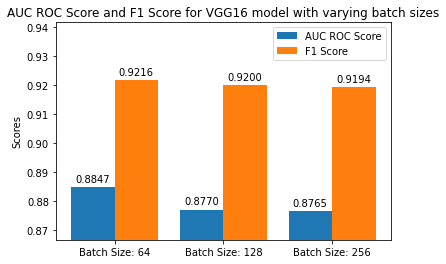

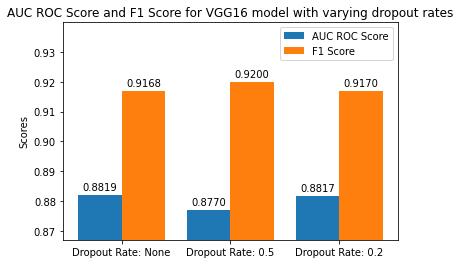

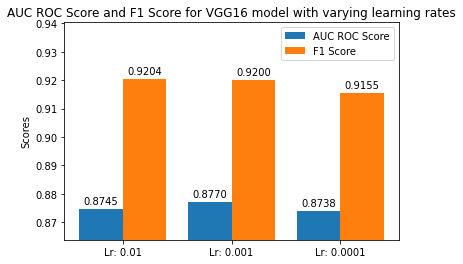

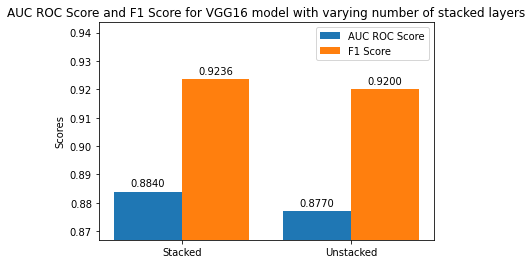

In [143]:
plot_scores('vgg16', params, labels, titles)

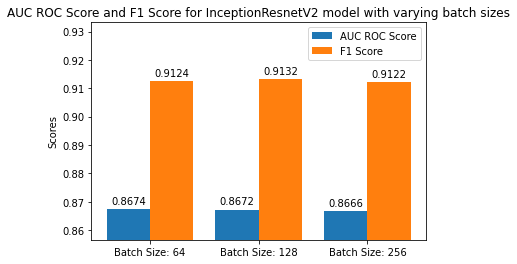

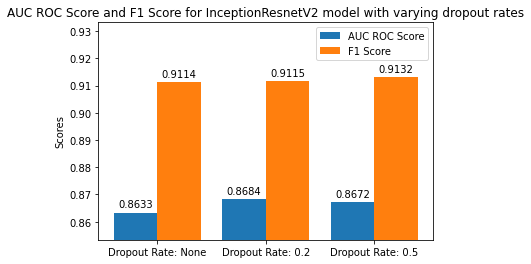

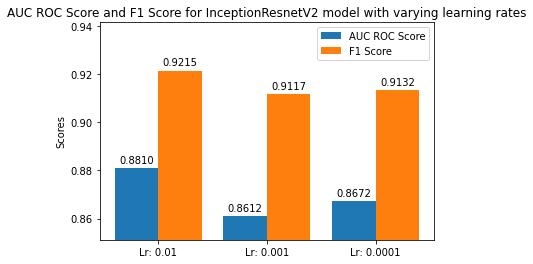

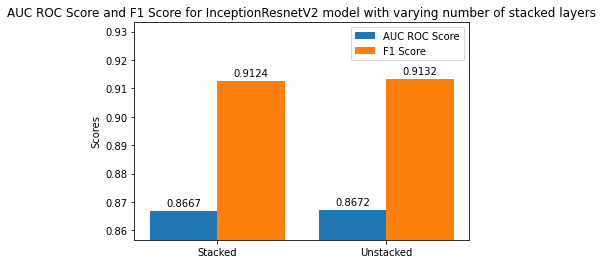

In [150]:
plot_scores('inceptionresnetv2', params, labels, titles)

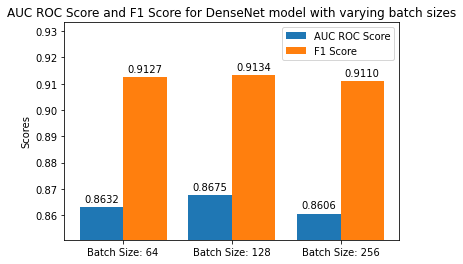

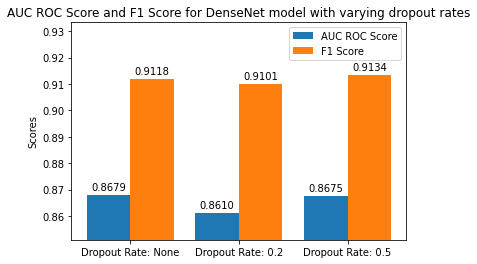

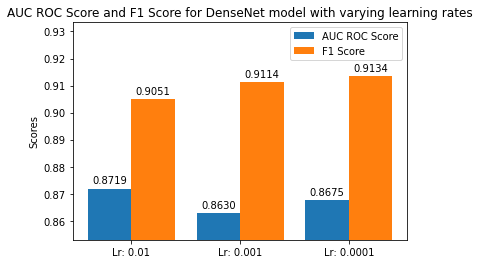

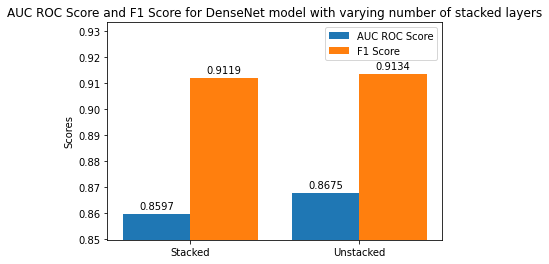

In [152]:
plot_scores('densenet201', params, labels, titles)

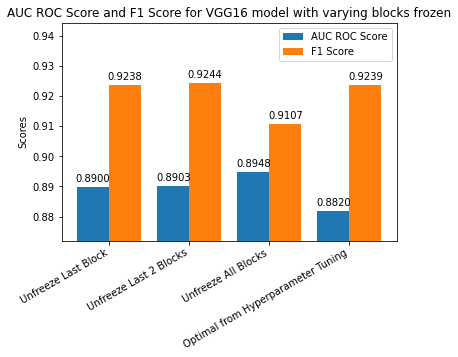

In [144]:
# Changing our parameters and labels for results obtained from Phase 5
params = [['unfreeze1Top', 'unfreeze2Top', 'unfreezeAll', 'optimal']]
labels = [['Unfreeze Block 1', 'Unfreeze Block 1 and 2', 'Unfreeze All Blocks', 'Optimal from Hyperparameter Tuning']]
titles = ['blocks frozen']
plot_scores('vgg16', params, labels, titles)

In [155]:
# The following are the three optimals from hyper parameter tuning
# inceptionresnet lr 0.01
# vgg optimal
# densenet stacked
def plot_optimal_scores(labels):
  title = 'AUC ROC Score and F1 Score for optimal models'
  roc_auc_scores = []
  f1_scores = []

  roc_auc_scores.append(get_roc_auc('results/roc_auc/inceptionresnetv2_lr0.01_roc_auc'))
  f1_scores.append(get_f1('results/csv/inceptionresnetv2_lr0.01_cr.csv'))

  roc_auc_scores.append(get_roc_auc('results/roc_auc/vgg16_optimal_roc_auc'))
  f1_scores.append(get_f1('results/csv/vgg16_optimal_cr.csv'))

  roc_auc_scores.append(get_roc_auc('results/roc_auc/densenet201_stacked_roc_auc'))
  f1_scores.append(get_f1('results/csv/densenet201_stacked_cr.csv'))

  plot_bar_graph(roc_auc_scores, f1_scores, labels, 'optimal', title, freeze=True)

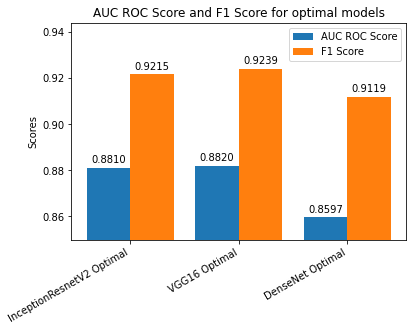

In [156]:
plot_optimal_scores(['InceptionResnetV2 Optimal', 'VGG16 Optimal', 'DenseNet201 Optimal'])

In [190]:
models = ['resnet50', 'inceptionv3', 'xception', 'densenet201', 'inceptionresnetv2', 'vgg16']
base_roc_auc_scores = []
base_f1_scores = []
for model in models:
 base_roc_auc_scores.append(get_roc_auc('results/roc_auc/{}_base_roc_auc'.format(model)))
 base_f1_scores.append(get_f1('results/csv/{}_base_cr.csv'.format(model)))

print(base_roc_auc_scores)
print(base_f1_scores)

[0.7604935353402051, 0.8373150871202663, 0.8615062981675552, 0.8675439248568738, 0.8672167035705903, 0.876961511059066]
[0.8343290555001548, 0.8943923581324617, 0.9036887129185386, 0.9133693477471309, 0.9132423063451346, 0.9199738934893968]


In [ ]:
df = get_val('results/max_val_acc_res')
df = df.loc[[0, 1, 2, 12, 21, 23], 'model':] # Locations of the 6 base models
df['roc_auc_score'] = base_roc_auc_scores
df['f1_score'] = base_f1_scores

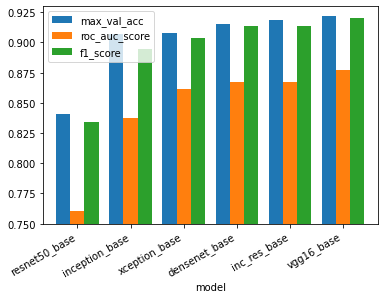

In [197]:
ax = df.plot.bar(x='model', y=['max_val_acc', 'roc_auc_score', 'f1_score'], rot=0, width=0.8)
ax.set_ylim([0.75,0.93])
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.savefig('{}/{}_bar.pdf'.format('results', 'basemodels'), dpi=100, bbox_inches='tight')